In [1]:
from src.training.data import *
from src.training.params import DataArguments, ModelArguments, TrainingArguments
from transformers import AutoProcessor
from torch.utils.data import DataLoader, random_split
import random

model_args, training_args = ModelArguments(), TrainingArguments()
data_args =  DataArguments(
    data_path = "/vast/palmer/home.mccleary/sv572/palmer_scratch/qwen_data_10k/formatted_dataset.json", 
    image_folder = "/vast/palmer/home.mccleary/sv572/palmer_scratch/qwen_data_10k/images",
    image_min_pixels = 256 * 28 * 28,
    image_max_pixels = 1280 * 28 * 28,
    lazy_preprocess = False)

processor = AutoProcessor.from_pretrained(model_args.model_id, padding_side="right")

sft_dataset = SupervisedDataset(
    data_path=data_args.data_path, processor=processor, data_args=data_args, model_id=model_args.model_id
)

# Calculate sizes for train, val, and test
total_size = len(sft_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

all_dataset = sft_dataset.list_data_dict
# Get total size and shuffle indices
all_indices = list(range(len(all_dataset)))
random.shuffle(all_indices)

# Split indices
train_size = int(0.8 * len(all_indices))
val_size = int(0.1 * len(all_indices))

train_indices = all_indices[:train_size]
val_indices = all_indices[train_size:train_size+val_size]

train_data = [all_dataset[i] for i in train_indices]
val_data = [all_dataset[i] for i in val_indices]

# data_collator = DataCollatorForSupervisedDataset(pad_token_id=processor.tokenizer.pad_token_id)
# val_dataloader = DataLoader(
#     sft_dataset,
#     batch_size=8,
#     shuffle=False,
#     collate_fn=data_collator,
# )

/vast/palmer/home.mccleary/sv572/project/.conda/envs/qwen2/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from peft import PeftModel
import os
from tqdm import tqdm
torch.cuda.set_device(torch.cuda.current_device())

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)
model = PeftModel.from_pretrained(model, "/vast/palmer/home.mccleary/sv572/project/BrainLMv2-dev/Qwen2-VL-Finetune/output/Qwen7B_UnfreezeVisionTower/checkpoint-5000")

# default processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")


messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Given this fMRI recording, what is the patient's age?\nRespond in JSON format: {\"age\": \"{age}\"}"},
        ],
    }
]

info = {"actual": [], "predicted": []}
for data in tqdm(val_data):
    messages[0]["content"][0]["image"] = os.path.join(data_args.image_folder, data["image"])
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(model.device)

    # Inference: Generation of the output
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    info["actual"].append(int(json.loads(data["conversations"][1]["value"])["age"]))
    info["predicted"].append(int(json.loads(output_text[0])["age"]))

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [07:56<00:00,  2.10it/s]


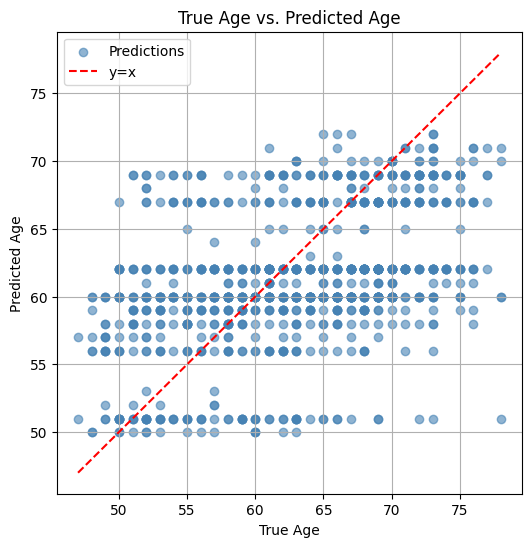

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import stats

def plot_histogram_ages(info):
    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(info["actual"], bins=range(int(min(info["actual"])), int(max(info["actual"])) + 2), alpha=0.6, color='steelblue', label='True Ages')
    plt.hist(info["predicted"], bins=range(int(min(info["predicted"])), int(max(info["predicted"])) + 2), alpha=0.6, color='sandybrown', label='Predicted Ages')

    # Labels and legend
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.title("Distribution of True and Predicted Ages for train_dataset")
    plt.legend()
    plt.show()
def plot_scatter_predictions(info):
    # Scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(info["actual"], info["predicted"], color='steelblue', alpha=0.6, label="Predictions")
    plt.plot([min(info["actual"]), max(info["actual"])], [min(info["actual"]), max(info["actual"])], 
            color='red', linestyle='--', label="y=x")

    # Labels and title
    plt.xlabel("True Age")
    plt.ylabel("Predicted Age")
    plt.title("True Age vs. Predicted Age")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_scatter_predictions(info)

In [4]:
from sklearn.preprocessing import StandardScaler
labels = []
for i in all_dataset:
    labels.append(int(json.loads(i["conversations"][1]["value"])["age"]))
z_score_transform = StandardScaler()
labels_normalized_np = z_score_transform.fit_transform(np.expand_dims(np.array(labels), axis=1))
actual_ages_norm = z_score_transform.transform(np.array(info["actual"]).reshape(-1, 1))
predicted_ages_norm = z_score_transform.transform(np.array(info["predicted"]).reshape(-1, 1))
mean_loss = mean_squared_error(predicted_ages_norm, actual_ages_norm)
res = stats.pearsonr(actual_ages_norm, predicted_ages_norm)
print(mean_loss, res.statistic[0])

0.9055955539240619 0.44586553171481635


In [7]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from peft import PeftModel

torch.cuda.set_device(torch.cuda.current_device())

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
    use_cache = False
)
model = PeftModel.from_pretrained(model, "/vast/palmer/home.mccleary/sv572/project/BrainLMv2-dev/Qwen2-VL-Finetune/output/lora_vision_3B")

# Preparation for inference
batch = next(iter(val_dataloader))
batch = {k: v.to(model.device) for k, v in batch.items()}

outputs = model(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    pixel_values=batch["pixel_values"],
    image_grid_thw=batch["image_grid_thw"]
)

# Assuming outputs contain logits or similar, decode them accordingly
# For causal LM, outputs.logits is usually [batch_size, seq_len, vocab_size]
logits = outputs.logits

# Optionally, get the predicted token IDs (e.g., greedy decoding)
predicted_ids = logits.argmax(dim=-1)

# Trim the inputs like you did before, if needed
predicted_ids_trimmed = [
    pred[len(inp):] for inp, pred in zip(batch["input_ids"], predicted_ids)
]

# Decode tokens to text
output_text = processor.batch_decode(
    predicted_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

# # Inference: Generation of the output
# generated_ids = model.generate(
#         input_ids=batch["input_ids"],
#         attention_mask=batch["attention_mask"],
#         pixel_values=batch["pixel_values"],
#         image_grid_thw=batch["image_grid_thw"]
#     )
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(batch["input_ids"], generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Some parameters are on the meta device because they were offloaded to the cpu.


['', '', '', '', '', '', '', '']


In [4]:
generated_ids

tensor([[151644,   8948,    198,  ...,    198, 151643, 151643],
        [151644,   8948,    198,  ..., 151643,    315, 151645],
        [151644,   8948,    198,  ...,    198, 151643, 151643],
        ...,
        [151644,   8948,    198,  ...,    198, 151643, 151643],
        [151644,   8948,    198,  ...,    198, 151643, 151643],
        [151644,   8948,    198,  ...,    198, 151643, 151643]],
       device='cuda:0')

In [3]:
model(input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    pixel_values=batch["pixel_values"],
    image_grid_thw=batch["image_grid_thw"])

Qwen2_5_VLCausalLMOutputWithPast(loss=None, logits=tensor([[[10.1875, 17.3750, 19.5000,  ...,  9.8750,  9.8750,  9.8750],
         [10.1875, 15.0625, 12.1250,  ...,  8.1250,  8.1250,  8.1250],
         [13.1875, 16.3750, 19.1250,  ...,  6.3438,  6.3438,  6.3438],
         ...,
         [ 7.3125,  8.7500,  5.8750,  ...,  3.8750,  3.8750,  3.8750],
         [ 8.3750,  1.7656,  0.5312,  ...,  3.6094,  3.6094,  3.6094],
         [ 4.3750,  5.3438, -1.8750,  ..., -0.1328, -0.1328, -0.1328]],

        [[10.1875, 17.3750, 19.5000,  ...,  9.8750,  9.8750,  9.8750],
         [10.1875, 15.0625, 12.1250,  ...,  8.1250,  8.1250,  8.1250],
         [13.1875, 16.3750, 19.1250,  ...,  6.3438,  6.3438,  6.3438],
         ...,
         [10.9375, 12.0625, 10.6875,  ...,  1.2344,  1.2344,  1.2344],
         [10.9375, 12.0625, 10.6875,  ...,  1.2344,  1.2344,  1.2344],
         [10.9375, 12.0625, 10.6875,  ...,  1.2344,  1.2344,  1.2344]],

        [[10.1875, 17.3750, 19.5000,  ...,  9.8750,  9.8750,  9.8

In [5]:
batch.generated_ids

AttributeError: 'dict' object has no attribute 'generated_ids'

In [7]:
for a in batch.values():
    print(a.shape)

torch.Size([8, 325])
torch.Size([8, 325])
torch.Size([8, 325])
torch.Size([7560, 1176])
torch.Size([8, 3])


In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from peft import PeftModel

torch.cuda.set_device(torch.cuda.current_device())

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)
model = PeftModel.from_pretrained(model, "/vast/palmer/home.mccleary/sv572/project/BrainLMv2-dev/Qwen2-VL-Finetune/output/lora_vision_3B")

# default processor
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Given this fMRI recording, what is the patient's age?\nRespond in JSON format: {\"age\": \"{age}\"}"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

/vast/palmer/home.mccleary/sv572/project/.conda/envs/qwen2/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


['{"age": "67"}']


In [2]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

In [6]:
for a in inputs.values():
    print(a.shape)

torch.Size([1, 3623])
torch.Size([1, 3623])
torch.Size([14308, 1176])
torch.Size([1, 3])
